<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Input-data" data-toc-modified-id="Input-data-1">Input data</a></span></li><li><span><a href="#Key-Components-of-an-AB-Test" data-toc-modified-id="Key-Components-of-an-AB-Test-2">Key Components of an AB Test</a></span><ul class="toc-item"><li><span><a href="#Running-an-AB-test-in-Abracadabra-is-as-easy-as-&quot;1,-2,-3&quot;:" data-toc-modified-id="Running-an-AB-test-in-Abracadabra-is-as-easy-as-&quot;1,-2,-3&quot;:-2.1">Running an AB test in Abracadabra is as easy as "1, 2, 3":</a></span><ul class="toc-item"><li><span><a href="#Hypotheses" data-toc-modified-id="Hypotheses-2.1.1">Hypotheses</a></span></li><li><span><a href="#Inference-Methods" data-toc-modified-id="Inference-Methods-2.1.2">Inference Methods</a></span></li><li><span><a href="#Example" data-toc-modified-id="Example-2.1.3">Example</a></span></li></ul></li></ul></li><li><span><a href="#Interpreting-results" data-toc-modified-id="Interpreting-results-3">Interpreting results</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Top-Plot:-Sample-Distributions" data-toc-modified-id="Top-Plot:-Sample-Distributions-3.0.1">Top Plot: Sample Distributions</a></span></li><li><span><a href="#Middle-Plot:-Central-Tendencies" data-toc-modified-id="Middle-Plot:-Central-Tendencies-3.0.2">Middle Plot: Central Tendencies</a></span></li><li><span><a href="#Bottom-Plot:-Deltas" data-toc-modified-id="Bottom-Plot:-Deltas-3.0.3">Bottom Plot: Deltas</a></span></li></ul></li></ul></li><li><span><a href="#Including-Segmentations" data-toc-modified-id="Including-Segmentations-4">Including Segmentations</a></span></li><li><span><a href="#Running-multiple-tests,-and-multiple-comparison-control" data-toc-modified-id="Running-multiple-tests,-and-multiple-comparison-control-5">Running multiple tests, and multiple comparison control</a></span></li><li><span><a href="#Custom-Metrics" data-toc-modified-id="Custom-Metrics-6">Custom Metrics</a></span></li><li><span><a href="#Continuous-Variables" data-toc-modified-id="Continuous-Variables-7">Continuous Variables</a></span></li><li><span><a href="#Bayesian-Hypothesis-Tests" data-toc-modified-id="Bayesian-Hypothesis-Tests-8">Bayesian Hypothesis Tests</a></span><ul class="toc-item"><li><span><a href="#Bayesian-Model-Specification" data-toc-modified-id="Bayesian-Model-Specification-8.1">Bayesian Model Specification</a></span></li></ul></li></ul></div>

# ✨Abracadabra✨ Basics

## Input data
Abracadabra takes as input a `pandas` `DataFrame` containing experiment observations data. Each record in the DataFrame represents an observation trial recorded in the experiment, and has the following columns:

- One or more `metric` columns: these are the values associated with each observation that are used to compare the two groups in the experiment.
- One or more `treatment` columns: each treatment column contains two or more distinct, discrete values that are used to identify the different groups in the experiment
- Zero or more columns that are associated with additional `attributes` assigned to the observations. These attributes can be used for any additional segmentations across experiment groups.

Below we use the `generate_fake_observations` utility function to create a dataset of artificial experiment observations.

In [1]:
from abra.utils import generate_fake_observations

# generate some fake binary trial data
binary_data = generate_fake_observations(
    distribution='bernoulli',  # binary data
    n_treatments=3,
    n_attributes=4,
    n_observations=1000
)
binary_data.head()

,id,treatment,attr_0,attr_1,attr_2,attr_3,metric
0,0,C,A0a,A1a,A2b,A3a,True
1,1,B,A0a,A1a,A2b,A3a,True
2,2,C,A0a,A1b,A2c,A3a,True
3,3,C,A0a,A1a,A2a,A3a,False
4,4,A,A0a,A1b,A2a,A3a,True


The resulting data have a single `treatment` column, called (creatively) `'treatment'`, a single `metric` column, called `'metric'`, and four `attribute` columns, `atr_0`, `attr_1`, `attr_2`, and `attr_3`. The `treatment` column has 3 distinct treatments: `"A"`, `"B"`, and `"C"`, and the metric takes on boolean/binary values drawn from a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution).

## Key Components of an AB Test

The three key components of running an AB test in ✨abracadabra✨ are:

- The `Experiment`, which holds the raw observations data recorded from, and any metadata associated with an AB experiment.
- The `HypothesisTest`, which defines the statistical inference procedure applied to the experiment data.
- The `HypothesisTestResults`, which is the statistical artifact that results from running a `HypothesisTest` against an `Experiment`'s observations. The `HypothesisTestResults` are used to summarize, visulize, and interpret the inference results and make decisions based on these results.

### Running an AB test in Abracadabra is as easy as "1, 2, 3":
1. Initialize your `Experiment` with observations and any metadata
2. Define your `HypothesisTest`. This requires defining the `hypothesis` and `inference_method`. The relevant inference method used will depend on the support of your observations. A list of supported hypotheses and inference methods for different types of observation variables are shown below:

#### Hypotheses
| Hypothesis | Hypothesis Type | `hypothesis` parameter  |
|---|---|---|
| "The treatment is larger than the control" | one-tailed | `"larger"` |
| "The treatment is smaller than the control" | one-tailed | `"smaller"` |
| "The treatment is not equal to the control" | two-tailed | `"unequal"` |


#### Inference Methods

| Variable Type | Model Class| `inference_method` parameter  |
|---|---|---|
| Continuous | Frequentist| `'means_delta'` (t-test) |
|  | Bayesian| `'gaussian'`, `'exp_student_t'`|
| Binary / Proportions | Frequentist| `'proportions_delta'` (z-test) |
|  | Bayesian| `'beta'`, `'beta_binomial'`, `'bernoulli'`  |
| Counts  |Frequentist| `'rates_ratio'`  |
|  |Bayesian| `'gamma_poisson'`  |

3. Run the test against your experiment and interpret the resulting `HypothesisTestResults`

#### Example

Below we demonstrate a standard AB test workflow in ✨abracadabra✨. Namely we:
1. Initialize an `Experiment` instance `exper` with our artifical binary observations generated above.
2. We then initialize a `HypothesisTest` instance `ab_test` that tests if `treatment` `"B"` is `"larger"` than treatment `"A"` based on the metric values in the `"metric"` column of the dataframe. The hypothesis test uses a Frequentist method `'proportions_delta'` that is dedicated to detecting differences between binary samples. 

In [2]:
from abra import Experiment, HypothesisTest

# Initialize the Experiment
exper = Experiment(data=binary_data, name="Demo Experiment")

# Initialize the A/B test
ab_test = HypothesisTest(
    metric="metric",
    treatment="treatment",
    control="A", variation="B",
    hypothesis="unequal",
    inference_method="proportions_delta"
)

# Run the test with an alpha of 0.5; get back a HypothesisTestResults object
ab_test_results = exper.run_test(ab_test, alpha=.05)

# Check the test results decision
assert ab_test_results.accept_hypothesis

## Interpreting results
Each `HypothesisTestResults` has its own `display()` and `visualize()` methods that can be used to interpret the results of the test. The `display()` method prints out the results to the console, while `visualize` plots a visual summary of the results.

In [3]:
# Print the test results to the console
ab_test_results.display()


Observations Summary:
+----------------+------------------+-----------------+
| Treatment      | A                | B               |
+----------------+------------------+-----------------+
| Metric         | metric           | metric          |
| Observations   | 318              | 345             |
| Mean           | 0.4528           | 0.5594          |
| Standard Error | (0.3981, 0.5075) | (0.507, 0.6118) |
| Variance       | 0.2478           | 0.2465          |
+----------------+------------------+-----------------+

Test Results:
+---------------------------+---------------------+
| ProportionsDelta          | 0.1066              |
| ProportionsDelta CI       | (0.0307, 0.1824)    |
| CI %-tiles                | (0.0250, 0.9750)    |
| ProportionsDelta-relative | 23.54 %             |
| CI-relative               | (6.79, 40.29) %     |
| Effect Size               | 0.2144              |
| alpha                     | 0.0500              |
| Power                     | 0.7877      

Providing an `outfile` argument to the `visualize` method will save the results figure to an image file.

Populating the interactive namespace from numpy and matplotlib
-rw-r--r--@ 1 dustinstansbury  wheel    26K Jun  3 14:26 /tmp/abracadabra_demo_test_results.png


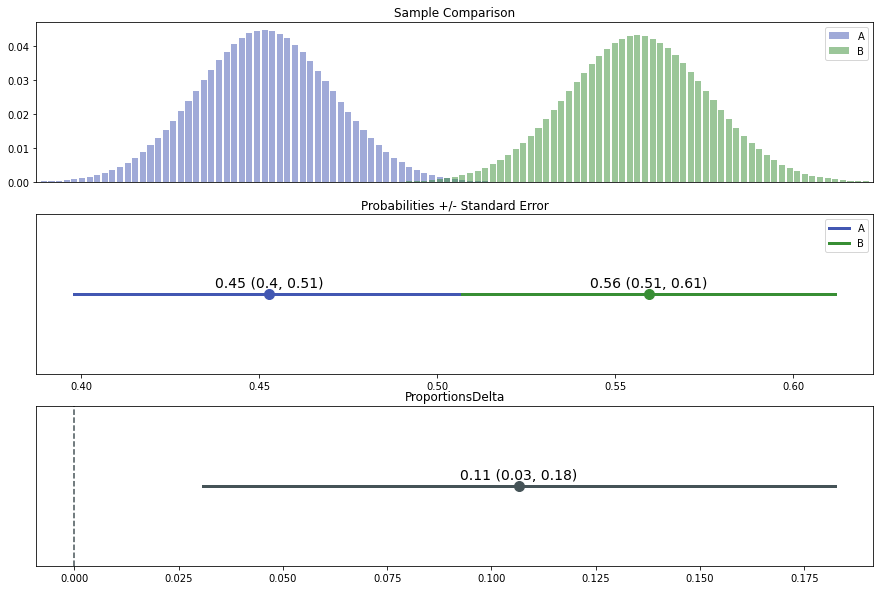

In [4]:
%pylab inline
# Visualize the test results
outfile = '/tmp/abracadabra_demo_test_results.png'
ab_test_results.visualize(outfile=outfile)

# Show that results figure exists
!ls -lah {outfile}

The resulting frequentist test results (displayed and visualized above) indicate that hypothesis `"B is larger"` should be accepted. A breakdown of the results plot is as follows:

#### Top Plot: Sample Distributions
The top plot compares the _parameterized representation of the sample distributions_ with parameters being derived from the experiment observations.

The large degree of separation between the two distributions indicates that the `"B"` group is qualitatively larger than `"A"`

#### Middle Plot: Central Tendencies
The middle plot compares the _central tendiency estimates_ of the two sample groups--in this case the, average probability of success on a given trial--as well as adds _Standard Errors_ calculate for the central tendency estimates.

We can see that there is no overlap of the standard errors, further indicating that we can be confident that the two groups are likely different, and that `"B"` is larger than `"A"`.

#### Bottom Plot: Deltas
The bottom plot gives the estimate of the _difference in central tendencies_, in this case `ProportionsDelta`, as well as 95% Confidence Intervals on this difference estimate (This is a one-tailed test, checking that `"B"` is larger than `"A"`, so the upper bound on ProportionsDelta is `inf`).

We can see that the confidence interval on the difference between the two groups does not intersect with the `ProportionsDelta=0` line, indicating a statistically significant difference between the two samples.

## Including Segmentations
✨abracdabra✨ supports the ability to segment experiment observations based on one or more attributes in your dataset using the `segmentation` argument to `HyptothesisTest`. The segmentation can be a string or list of string expressions, each of which follow the [pandas query API](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.query.html)


Observations Summary:
+----------------+------------------+-----------------+
| Treatment      | A                | B               |
+----------------+------------------+-----------------+
| Metric         | metric           | metric          |
| Observations   | 97               | 101             |
| Mean           | 0.5258           | 0.5842          |
| Standard Error | (0.4264, 0.6251) | (0.488, 0.6803) |
| Variance       | 0.2493           | 0.2429          |
+----------------+------------------+-----------------+

Test Results:
+---------------------------+---------------------+
| ProportionsDelta          | 0.0584              |
| ProportionsDelta CI       | (-0.0582, inf)      |
| CI %-tiles                | (0.0500, inf)       |
| ProportionsDelta-relative | 11.10 %             |
| CI-relative               | (-11.07, inf) %     |
| Effect Size               | 0.1177              |
| alpha                     | 0.0500              |
| Power                     | 0.2070      

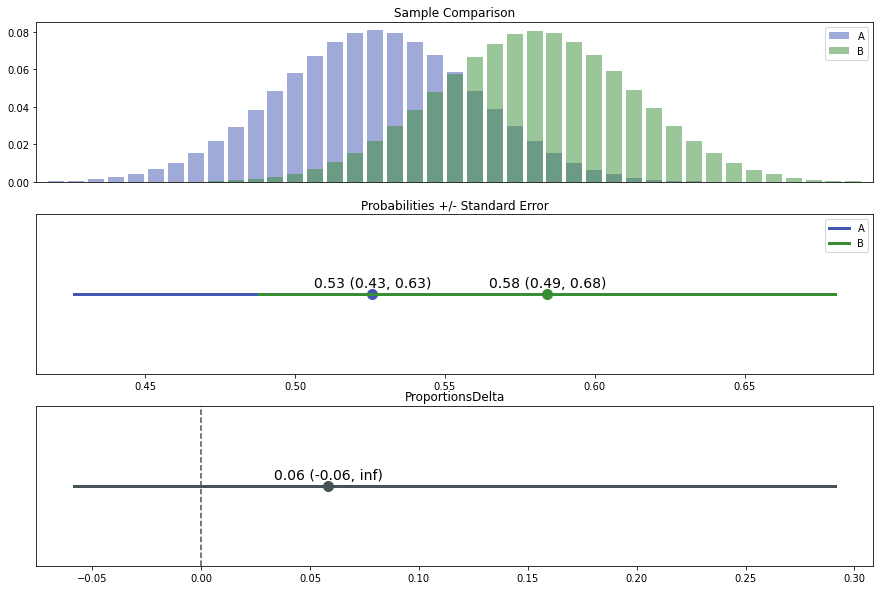

In [5]:
# Initialize an A/B test with additional segmentation on the 'attr_1' attribute
ab_test_segmented = HypothesisTest(
    metric='metric',
    control='A', variation='B',
    inference_method='proportions_delta',
    hypothesis='larger',
    segmentation="attr_1 == 'A1a'"
)

# Run the segmented test
ab_test_segmented_results = exper.run_test(ab_test_segmented)
assert not ab_test_segmented_results.accept_hypothesis  # B is larger

# Display results (notice reduced sample sizes)
ab_test_segmented_results.display()
ab_test_segmented_results.visualize()

We now see that if we dig into a particular segment, namely the segement defined by `"attr_1 == 'A1a'"`, we can no longer accept the hypothesis that `"B is larger"`. This is indicated by a `ProportionsDelta` that overlaps substantially with the line indicating `0` difference between the two samples.

## Running multiple tests, and multiple comparison control
When running multiple tests on the same metric, you'll need to control for [multiple comparisons](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). This is handled by running a `HypothesisTestSuite`, which takes in a list of hypothesis tests.

Below we run 3 independent tests comparing A to A, B to A and C to A, and set the correction `method` to `'bonferonni'`, which simply updates the effective $\alpha_{corrected} = \frac{\alpha}{N_{tests}}$. Our original value for `alpha=0.05`, thus the corrected value would be $\frac{0.05}{3} = 0.0167$

In [6]:
from abra.hypothesis_test import HypothesisTestSuite
from copy import deepcopy

# Use the `HypothesisTest.copy` method for duplicating tests
# configurations, while overwriting specific parameters
aa_test = ab_test.copy(variation='A')
ac_test = ab_test.copy(variation='C')

# Initialize the `HypothesisTestSuite`
test_suite = HypothesisTestSuite(
    tests=[aa_test, ab_test, ac_test],
    correction_method='bonferroni'
)

# Run tests
test_suite_results = exper.run_test_suite(test_suite)

print(test_suite_results)

# Print results
test_suite_results.display()

HypothesisTestSuiteResults(ntests=3, correction_method='bonferroni')
------------------------------------------------------------
Test 1 of 3

Observations Summary:
+----------------+-----------------+-----------------+
| Treatment      | A               | A               |
+----------------+-----------------+-----------------+
| Metric         | metric          | metric          |
| Observations   | 318             | 318             |
| Mean           | 0.4528          | 0.4528          |
| Standard Error | (0.386, 0.5197) | (0.386, 0.5197) |
| Variance       | 0.2478          | 0.2478          |
+----------------+-----------------+-----------------+

Test Results:
+---------------------------+---------------------+
| ProportionsDelta          | 0.0000              |
| ProportionsDelta CI       | (-0.0841, inf)      |
| CI %-tiles                | (0.0167, inf)       |
| ProportionsDelta-relative | 0.00 %              |
| CI-relative               | (-18.58, inf) %     |
| Effect Size

Note that the alpha has been `corrected` with `MC Correction='bonferroni'`

In [7]:
# test_suite_results.visualize()

The `HypothesisTestSuite` supports the following multiple comparison strategies:
- [Sidak](http://en.wikipedia.org/wiki/%C5%A0id%C3%A1k_correction) (default)
- [Bonferonni](http://en.wikipedia.org/wiki/Bonferroni_correction)
- [Benjamini-Hochberg false-discovery rate](http://pdfs.semanticscholar.org/af6e/9cd1652b40e219b45402313ec6f4b5b3d96b.pdf)

## Custom Metrics
Abracadabra also supports the use of custom metrics, which can transform and combine information from one or more columns. Below we create a `CustomMetric` always makes the `variation` greater than the `control` by adding a constant offset (plus noise) to the value of the the `control`.

In [8]:
from abra import CustomMetric
import numpy as np

def custom_metric(row):
    """
    Define a custom 'metric' where the control is always better.
    """
    return 4 + np.random.rand() if row['treatment'] == 'A' else np.random.rand()

custom_test = HypothesisTest(
    metric=CustomMetric(custom_metric),
    control='A',
    variation='B',
    inference_method='means_delta',  # Note we use a t-test here
    hypothesis='unequal'
)

custom_test = exper.run_test(custom_test)
custom_test.display()


Observations Summary:
+----------------+-----------------+-----------------+
| Treatment      | A               | B               |
+----------------+-----------------+-----------------+
| Metric         | custom_metric   | custom_metric   |
| Observations   | 318             | 345             |
| Mean           | 4.4751          | 0.5239          |
| Standard Error | (4.4442, 4.506) | (0.493, 0.5547) |
| Variance       | 0.0791          | 0.0854          |
+----------------+-----------------+-----------------+

Test Results:
+----------------------+--------------------+
| MeansDelta           | -3.9512            |
| MeansDelta CI        | (-3.9949, -3.9075) |
| CI %-tiles           | (0.0250, 0.9750)   |
| MeansDelta-relative  | -88.29 %           |
| CI-relative          | (-89.27, -87.32) % |
| Effect Size          | -13.7631           |
| alpha                | 0.0500             |
| Power                | 1.0000             |
| Inference Method     | 'means_delta'      |
| Test 

We see that, as expected, we have highly significant results, accepting the hypothesis that `'B != A'`

## Continuous Variables

## Bayesian Hypothesis Tests
In addition to common Frequentist test, running Bayesian analogs is simple. Simply intitialize the `HypothesisTest` with a Bayesian `method` parameter. For example, the Bayesian analogs to the `'proportions_delta'` method are the `'binomial'`, `'beta_binomial'`, or `'bernoulli'` methods.


Observations Summary:
+----------------+------------------+-----------------+
| Treatment      | A                | B               |
+----------------+------------------+-----------------+
| Metric         | metric           | metric          |
| Observations   | 318              | 345             |
| Mean           | 0.4528           | 0.5594          |
| Standard Error | (0.3981, 0.5075) | (0.507, 0.6118) |
| Variance       | 0.2478           | 0.2465          |
+----------------+------------------+-----------------+

Test Results:
+------------------------+-------------------------------+
| Delta                  | 0.1057                        |
| HDI                    | (0.0344, 0.1853)              |
| HDI %-tiles            | (0.0500, 0.9500)              |
| Delta-relative         | 23.79 %                       |
| HDI-relative           | (5.91, 43.62) %               |
| Effect Size            | 0.2133                        |
| alpha                  | 0.0500            

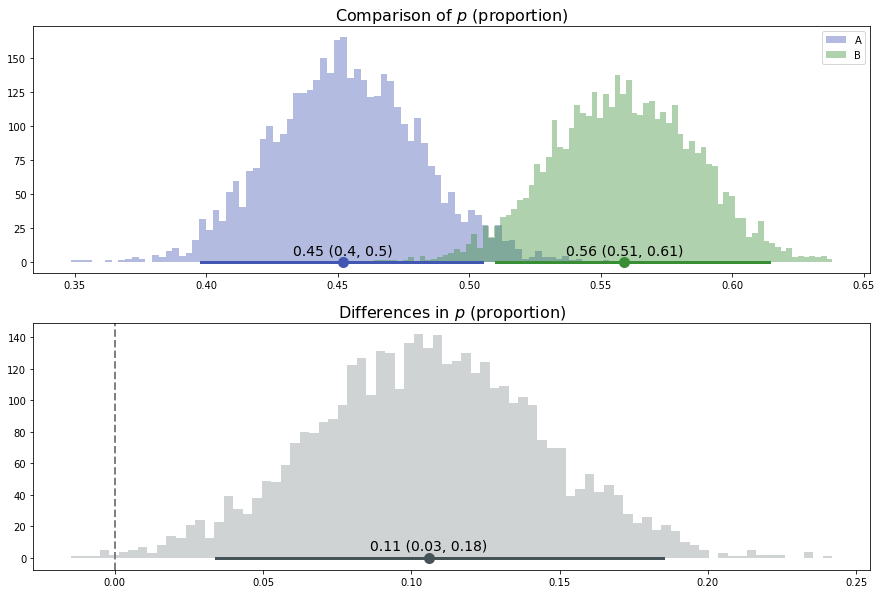

In [9]:
# set up Bayesian A/B test with default priors
binomial_ab_test = HypothesisTest(
    metric='metric',
    control='A',
    variation='B',
    inference_method='binomial'
)

# run the test
binomial_ab_test_results = exper.run_test(binomial_ab_test)
assert binomial_ab_test_results.prob_greater > .95
binomial_ab_test_results.display()
binomial_ab_test_results.visualize()

Bayesian `HypothesisTestResults` have their own analogous `display` and `visualize` methods that can be used to interpret the results of the analysis. Notice the results of the `ab_test_results` and `binomial_ab_test_results` each support a difference in proportions of approximately 0.14.

### Bayesian Model Specification
Bayesian models allow the experimenter to incorporate prior beliefs. This can be helpful when you have little data, or have strong domain knowledge of baselines. Specifying custom priors is also straight-forward using `abracadaba`, simply pass in a a `model_params` argument during `HypothesisTest` initialization:


Observations Summary:
+----------------+------------------+-----------------+
| Treatment      | A                | B               |
+----------------+------------------+-----------------+
| Metric         | metric           | metric          |
| Observations   | 318              | 345             |
| Mean           | 0.4528           | 0.5594          |
| Standard Error | (0.3981, 0.5075) | (0.507, 0.6118) |
| Variance       | 0.2478           | 0.2465          |
+----------------+------------------+-----------------+

Test Results:
+------------------------+-------------------------------+
| Delta                  | 0.1057                        |
| HDI                    | (0.0344, 0.1853)              |
| HDI %-tiles            | (0.0500, 0.9500)              |
| Delta-relative         | 23.79 %                       |
| HDI-relative           | (5.91, 43.62) %               |
| Effect Size            | 0.2133                        |
| alpha                  | 0.0500            

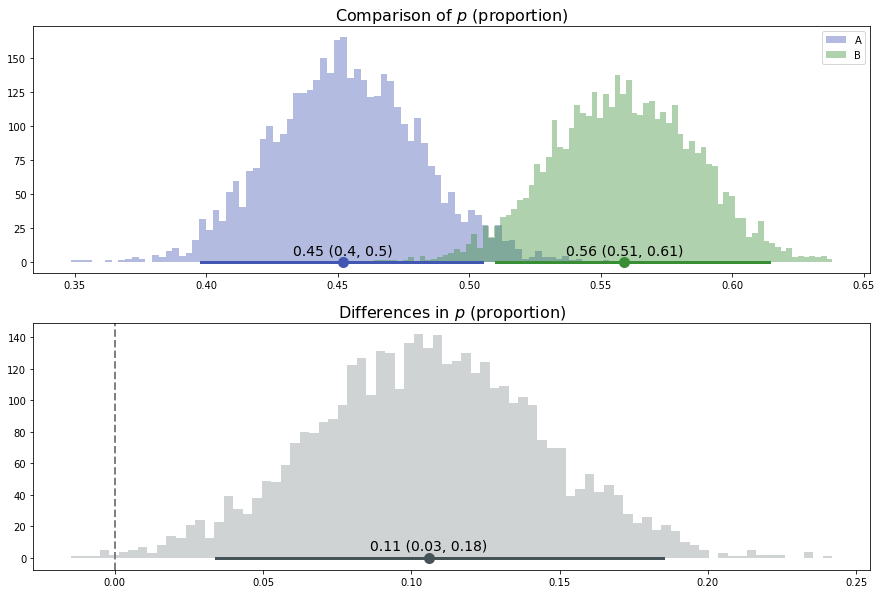

In [10]:
# Run Bayesian test with custom priors
beta_prior_params = dict(alpha=100., beta=100.)  # strong prior at p = .5
bb_ab_test = HypothesisTest(
    metric='metric',
    control='A', variation='C',
    inference_method='beta_binomial',
    model_params=beta_prior_params
)

# run the test
binomial_ab_test_results = exper.run_test(binomial_ab_test)
assert binomial_ab_test_results.prob_greater > .95
binomial_ab_test_results.display()
binomial_ab_test_results.visualize()